In [2]:
import gdelt
import time
import re
import matplotlib.pyplot as plt
import numpy as np
from pycorenlp import StanfordCoreNLP
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
# Collecting the newslinks from GDELT2.0
startdate='2019 10 15'
enddate='2019 11 03'
gd = gdelt.gdelt(version=2)
results = gd.Search([startdate,enddate],table='events',coverage=True,translation=False)
results.shape
type(results)

c:\users\mario\appdata\local\programs\python\python36\lib\site-packages\gdelt\dateFuncs.py:241: UserWarning: This query will download 1920 files, and likely exhaust your memory with possibly 10s of GBs of data in this single query.Hit Ctr-C to kill this query if you do not want to continue.
  warnings.warn(warnText)


pandas.core.frame.DataFrame

In [5]:
#Keeping the useful columns
mycolumns=['GLOBALEVENTID','NumArticles','AvgTone','ActionGeo_FullName', 'ActionGeo_CountryCode','DATEADDED', 'SOURCEURL']
results=results[mycolumns]
results.shape

(3028496, 7)

In [8]:
#Keeping one copy of an url that is registered in multiple dates
results=results.drop_duplicates(subset=['SOURCEURL'])
results.shape

(645142, 7)

In [9]:
#Cleaning the urls to retrieve the website of the news paper and the keywords from the urls
results['website'] = [re.split(r'/|-|_',x) for x in results['SOURCEURL']]
results.shape

(645142, 8)

In [10]:
results['website'] =results['website'].apply(lambda x:" ".join(y for y in x if (y not in ["http:","https:","html"] and not y.isnumeric())))
results.shape

(645142, 8)

In [11]:
results['title']= results['website'].apply(lambda x: " ".join(x.split()[1:]))
results.shape

(645142, 9)

In [12]:
results['website']= results['website'].apply(lambda x: x.split()[0])
results.shape

(645142, 9)

In [13]:
results.shape

(645142, 9)

In [15]:
#Apply key word filter
filtered=results[results["title"].str.contains('tesla',na=False)]
filtered.shape

(262, 9)

In [16]:
#Scrapper that retrieves paragraphs that are between 50 and 999 characters
def gettext(url):
    minparagraph=50
    maxtotal=999
    result = requests.get(url)
    c = result.content
    soup = BeautifulSoup(c)
    tempnews=[]
    count=0
    for tag in soup.findAll('p'):
        temptext=tag.getText()
        count+=len(temptext)
        if len(temptext)>minparagraph and count<maxtotal:
            tempnews.append(temptext)
    tempnews=" ".join(x for x in tempnews)
    return tempnews

In [19]:
filtered["SOURCEURL"].tolist()[3]

'https://www.thestreet.com/investing/stocks/tesla-powerwall-home-battery-installations-japan-15126467'

In [20]:
tempnews=gettext(filtered["SOURCEURL"].tolist()[3])
tempnews

'Tesla \n (TSLA) - Get Report \xa0will debut its Powerwall home power storage batteries in Asia early next year, starting in Japan,\xa0Reuters reported\xa0on Tuesday. "Tesla believes that the Japanese home battery market has big growth potential," Shinji Asakura, country manager of energy products for Tesla in Japan, told reporters in Tokyo.\xa0 Asakura said the expiry of\xa0feed-in-tariffs, starting later this year, is expected to promote self-consumption of solar power by households and spur demand for home-use batteries. About 530,000 households with solar panels will have supply contracts with utilities lapse during the last two months of this year, Bloomberg reported, citing data from Japan\'s Agency for Natural Resources and Energy. By the end of 2023, it estimates about 1.65 million residential units that comprise about 6.7 gigawatts of solar\xa0will\xa0expire.'

In [21]:
#Scrapping the text from the URL
filtered['text']= filtered['SOURCEURL'].apply(lambda x: gettext(x))

c:\users\mario\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
filtered.shape

(262, 10)

In [23]:
filtered2=filtered.drop_duplicates(subset=['text'])
filtered2.shape

(208, 10)

In [56]:
my_dataframe = filtered2[filtered2.text != ""]
my_dataframe.shape

(207, 10)

In [57]:
my_dataframe.to_csv("teslafiltered.csv")

In [ ]:
#Initiating the Stanford Core NLP Server
nlp = StanfordCoreNLP('http://140.247.196.191:64000')

In [59]:
#Requesting sentiment
starttime=time.time()
result = nlp.annotate(tempnews, properties={ 'annotators': 'sentiment', 'outputFormat': 'json','timeout': 30000,})
endtime=time.time()
print(endtime-starttime)

2.9823100566864014


In [29]:
#Function that provides average sentiment from Stanford Core NLP output
def avgsent(text):
    sentiment=0
    sentiments=[]
    result = nlp.annotate(text, properties={ 'annotators': 'sentiment', 'outputFormat': 'json','timeout': 30000,})
    for sentence in result["sentences"]:
        sentiments.append(int(sentence["sentimentValue"]))
        sentiment=sentiment+int(sentence["sentimentValue"])
    avgsentiment=sentiment/len(result["sentences"])
    return avgsentiment

In [73]:
my_dataframe["avgsent"]=""

c:\users\mario\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
print("Total number of iterations: ",len(my_dataframe["text"])

In [ ]:
# First used a lambda expression but since Stanford Core NLP sometimes crashes I resulte to the below to handle exeptions
starttime=time.time()
i=0

for x in my_dataframe["text"]:
    try:
        my_dataframe["avgsent"]=""
        my_dataframe["avgsent"].iloc[i] = avgsent(x)
        print(i,end = ',')
        i+=1
    except:
        print("Error in line:",i)
        pass
endtime=time.time()
print(endtime-starttime)

0,1,2,3,4,Error in line: 5
5,6,7,8,9,Error in line: 10
Error in line: 10
Error in line: 10
10,Error in line: 11
Error in line: 11
Error in line: 11
11,12,Error in line: 13
13,14,Error in line: 15
15,16,17,18,19,20,21,22,23,24,Error in line: 25
25,26,Error in line: 27
27,28,

In [135]:
my_dataframe.to_csv("myoutputdata.csv")

In [3]:
my_dataframe=pd.read_csv('myoutputdata.csv')

In [90]:
# Playing with wordcloud
from wordcloud import WordCloud
mycloud = " ".join(my_dataframe.title)
wc=WordCloud(width=4000,height=2000).generate(mycloud)

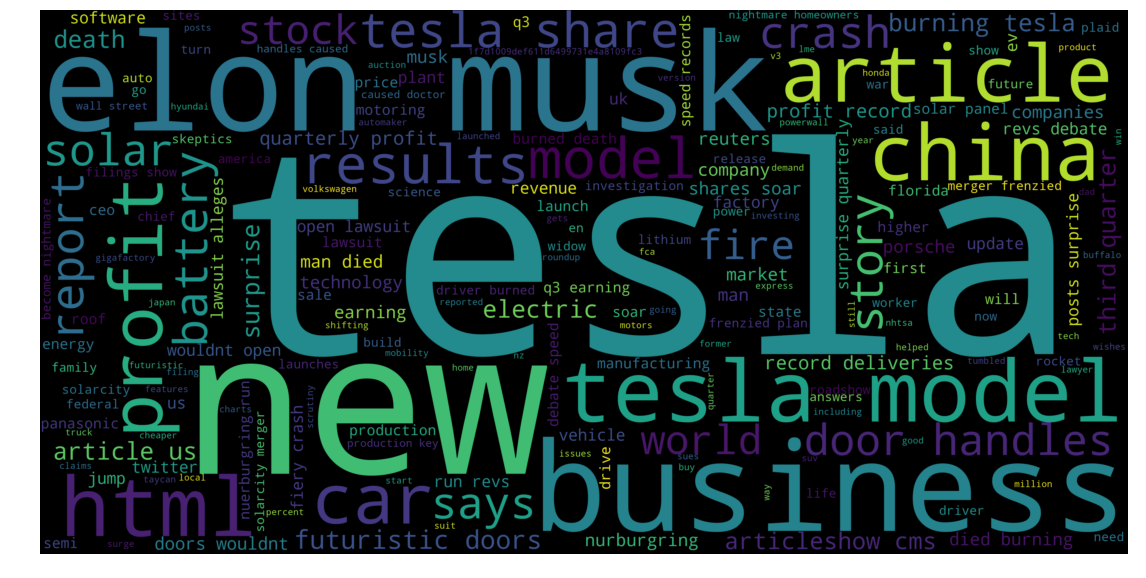

In [93]:
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [5]:
bydatedf=my_dataframe.groupby(['DATEADDED']).mean()

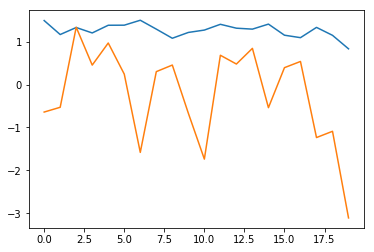

In [6]:
plt.plot(bydatedf["avgsent"].tolist())
plt.plot(bydatedf["AvgTone"].tolist())
plt.show()

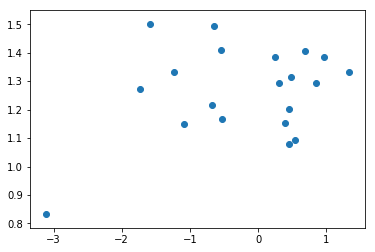

In [7]:
plt.scatter(bydatedf["AvgTone"].tolist(),bydatedf["avgsent"].tolist())

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df=bydatedf
column_names_to_normalize = ['avgsent', 'AvgTone']
x =df[column_names_to_normalize].values
x_scaled = scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = df.index)
df[column_names_to_normalize] = df_temp

(array([13.,  5., 16., 15., 20., 39., 48., 30., 13.,  9.]),
 array([-7.3313783 , -6.01946233, -4.70754637, -3.3956304 , -2.08371444,
        -0.77179847,  0.54011749,  1.85203346,  3.16394942,  4.47586539,
         5.78778135]),
 <a list of 10 Patch objects>)

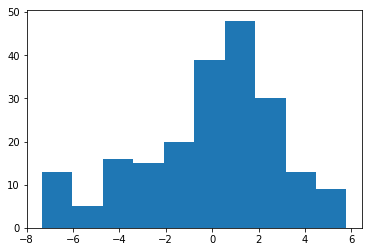

In [19]:
plt.hist(my_dataframe["AvgTone"])

(array([ 4.,  6.,  4., 96., 38., 29., 19.,  5.,  3.,  4.]),
 array([0.33333333, 0.55      , 0.76666667, 0.98333333, 1.2       ,
        1.41666667, 1.63333333, 1.85      , 2.06666667, 2.28333333,
        2.5       ]),
 <a list of 10 Patch objects>)

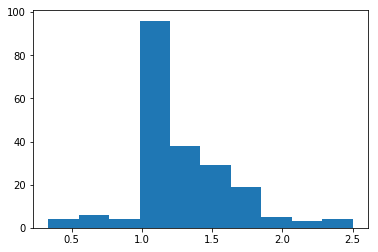

In [20]:
plt.hist(my_dataframe["avgsent"])

(array([1., 0., 0., 2., 2., 4., 0., 3., 6., 2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

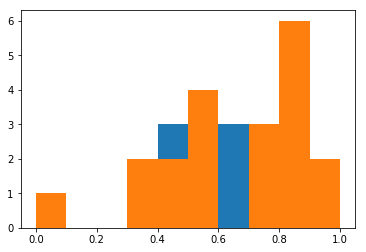

In [18]:
plt.hist(df["avgsent"])
plt.hist(df["AvgTone"])